In [1]:
import torch
import torch.fft
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [2]:
# Load image (128x128 RGB)
img = Image.open('epochs/example_imgs/img_0.png')
img_tensor = torch.tensor(np.array(img), dtype=torch.float32) / 255.0  # Normalize to [0, 1]
img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0)  # Convert to (1, 3, 128, 128)


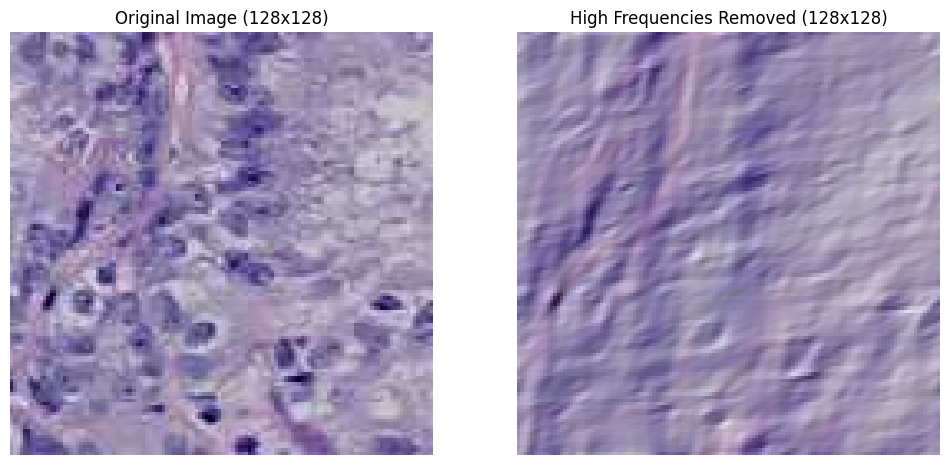

In [3]:
# Apply Real FFT
fft_img = torch.fft.rfft2(img_tensor)

# Set high frequencies to zero (simulate downsampling to 64x64)
H, W = img_tensor.shape[-2], img_tensor.shape[-1] // 2 + 1  # RFFT dimensions
fft_img[:, :, 64:, :] = 0  # Zero out rows (frequencies beyond 64)
fft_img[:, :, :, 33:] = 0  # Zero out columns (frequencies beyond 64x64 in RFFT)

# Inverse Real FFT to reconstruct the image
downsampled_img = torch.fft.irfft2(fft_img, s=(128, 128)).clamp(0, 1)

# Plot original and "downsampled" images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_tensor.squeeze().permute(1, 2, 0).numpy())
plt.title('Original Image (128x128)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(downsampled_img.squeeze().permute(1, 2, 0).numpy())
plt.title('High Frequencies Removed (128x128)')
plt.axis('off')

plt.show()

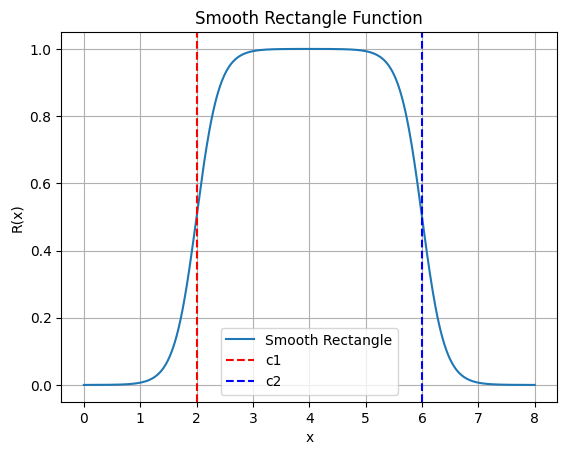

In [44]:
import numpy as np
import matplotlib.pyplot as plt

def smooth_rectangle(x, a, c1, c2):
    sigmoid1 = 1 / (1 + np.exp(-a * (x - c1)))
    sigmoid2 = 1 / (1 + np.exp(-a * (c2 - x)))
    return sigmoid1 * sigmoid2

# Parameters
a = 5
c1 = 2
c2 = 6
x = np.linspace(0, 8, 500)

# Compute the function
y = smooth_rectangle(x, a, c1, c2)

# Plot
plt.plot(x, y, label="Smooth Rectangle")
plt.xlabel("x")
plt.ylabel("R(x)")
plt.title("Smooth Rectangle Function")
plt.axvline(c1, color='red', linestyle='--', label="c1")
plt.axvline(c2, color='blue', linestyle='--', label="c2")
plt.legend()
plt.grid()
plt.show()


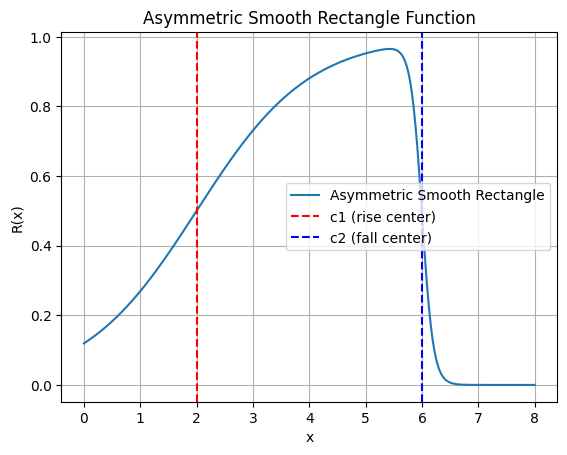

In [46]:
import numpy as np
import matplotlib.pyplot as plt

def asymmetric_smooth_rectangle(x, a1, a2, c1, c2):
    if c1 >= c2:
        raise ValueError("c1 must be less than c2 for a valid rectangle.")
    sigmoid1 = 1 / (1 + np.exp(-a1 * (x - c1)))
    sigmoid2 = 1 / (1 + np.exp(-a2 * (c2 - x)))
    return sigmoid1 * sigmoid2

# Parameters
a1 = 1  # Steepness of the ascending side
a2 = 10   # Steepness of the descending side
c1 = 2   # Center of the ascending transition
c2 = 6   # Center of the descending transition
x = np.linspace(0, 8, 500)

# Compute the function
y = asymmetric_smooth_rectangle(x, a1, a2, c1, c2)

# Plot
plt.plot(x, y, label="Asymmetric Smooth Rectangle")
plt.xlabel("x")
plt.ylabel("R(x)")
plt.title("Asymmetric Smooth Rectangle Function")
plt.axvline(c1, color='red', linestyle='--', label="c1 (rise center)")
plt.axvline(c2, color='blue', linestyle='--', label="c2 (fall center)")
plt.legend()
plt.grid()
plt.show()


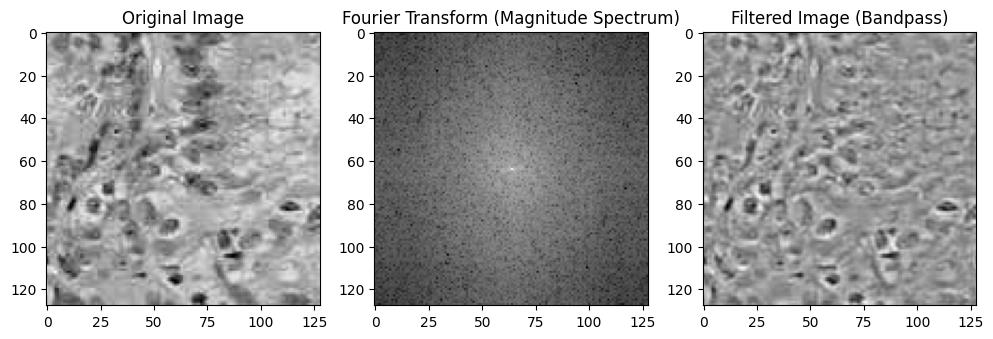

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load grayscale image
image = cv2.imread("epochs/example_imgs/img_0.png", cv2.IMREAD_GRAYSCALE)
M, N = image.shape

# Compute the 2D Fourier Transform
F = np.fft.fft2(image)
F_shifted = np.fft.fftshift(F)  # Shift zero frequency to center

# Create frequency grid
u = np.arange(M)
v = np.arange(N)
u, v = np.meshgrid(u - M//2, v - N//2)  # Shift origin to center
D = np.sqrt(u**2 + v**2)  # Compute distance from center

# Define frequency cutoffs
D_low = 10   # Remove low frequencies
D_high = max(64-D_low,0)  # Remove high frequencies

# Create bandpass mask
mask = np.logical_and(D >= D_low, D <= D_high).astype(np.float32)

# Apply mask
F_filtered = F_shifted * mask

# Inverse Fourier Transform
F_inv_shifted = np.fft.ifftshift(F_filtered)  # Shift back
image_filtered = np.fft.ifft2(F_inv_shifted).real  # Inverse transform

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(np.log(1 + np.abs(F_shifted)), cmap='gray')  # Log scale for visibility
plt.title("Fourier Transform (Magnitude Spectrum)")

plt.subplot(1, 3, 3)
plt.imshow(image_filtered, cmap='gray')
plt.title("Filtered Image (Bandpass)")

plt.show()
